In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pyampd import ampd
import scipy.signal as signal
import scipy.ndimage as ndimage
from scipy.signal import ShortTimeFFT, windows


def db(x):
    return 10 * np.log10(x)
    

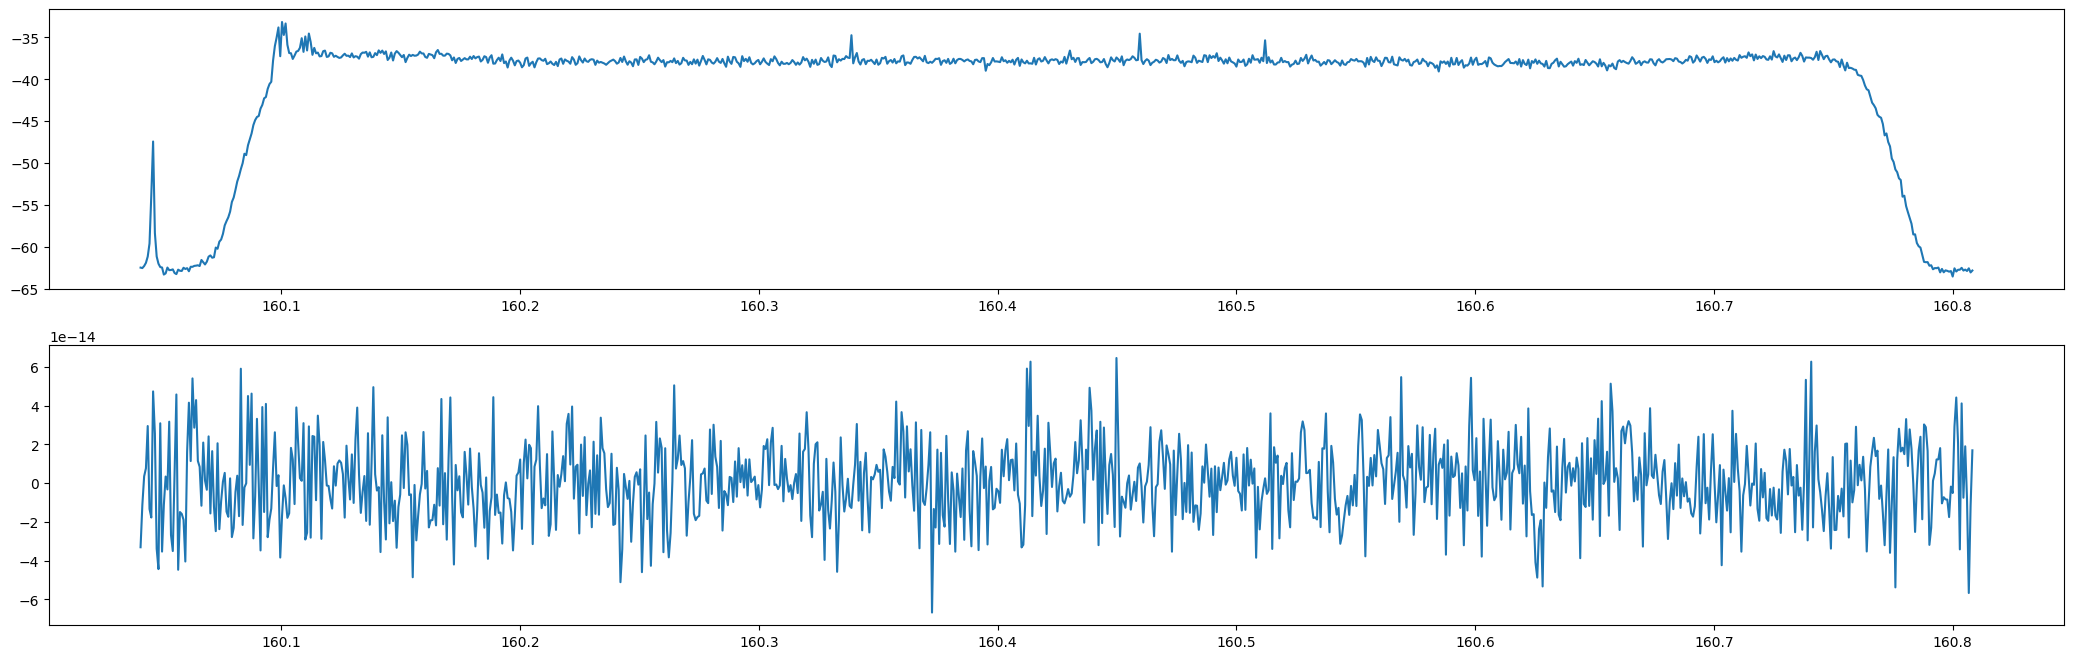

In [ ]:
# load raw samples
data = np.fromfile("../data/test_lna_on_agc_on.fc32", dtype=np.complex64)
# data = np.fromfile("../data/test_multiple.fc32", dtype=np.complex64)
d = data[768_000:1024_000]
fs = 768_000  # sampling frequency
f0  = 160425000
N_fft = 1024

# Generate array of channel frequencies
f = (np.fft.fftshift(np.fft.fftfreq(N_fft, 1/fs)) + f0) / 1e6

# Time tag each sample
t = np.arange(len(d)) / fs

# Reshape so we can do an FFT over an axis
d_fft = d.reshape((-1, N_fft))
D = np.fft.fftshift(np.fft.fft(d_fft, axis=1), axes=(1,))

# Time tag each sample coming from a channel
T = np.arange(len(D)) / fs * N_fft

# Now convert into power spectral density
# 1. Reshape to (N_timestep, N_int_per_timestep, N_fft)
# 2. Square
# 3. Sum over N_int_per_timestep axis
N_time_PSD = 250
PSD = (np.abs(D.reshape((N_time_PSD, -1, N_fft)))**2).mean(axis=1)

# Create overall spectrum
spec = PSD.mean(axis=0)



P = db(PSD)
# PSD PLOTS
figure, ax2 = plt.subplots(2,1, figsize = (26,8))
# NORMAL PSD
ax2[0].plot(f, db(spec))
# PSD WITH BASELINE NOISE REMOVED
baseline = np.mean(P, axis=0) # GET BASELINE
spec = P - baseline # SUBTRACT BASELINE FROM P
spec_adj = spec.mean(axis = 0) # RECALC NEW MEAN FOR SPEC WITHOUT BASELINE
ax2[1].plot(f, spec_adj)
plt.show()



